Epoch [13/50], Train Loss: 0.013515, Val Loss: 0.013486
Epoch [14/50], Train Loss: 0.013181, Val Loss: 0.013200
Epoch [15/50], Train Loss: 0.012929, Val Loss: 0.012964
Epoch [16/50], Train Loss: 0.012694, Val Loss: 0.012823
Epoch [17/50], Train Loss: 0.012487, Val Loss: 0.012539
Epoch [18/50], Train Loss: 0.012303, Val Loss: 0.012439
Epoch [19/50], Train Loss: 0.012146, Val Loss: 0.012301
Epoch [20/50], Train Loss: 0.011986, Val Loss: 0.012133
Epoch [21/50], Train Loss: 0.011877, Val Loss: 0.012051
Epoch [22/50], Train Loss: 0.011761, Val Loss: 0.011945
Epoch [23/50], Train Loss: 0.011626, Val Loss: 0.011835
Epoch [24/50], Train Loss: 0.011528, Val Loss: 0.011720
Epoch [25/50], Train Loss: 0.011433, Val Loss: 0.011704
Epoch [26/50], Train Loss: 0.011331, Val Loss: 0.011563
Epoch [27/50], Train Loss: 0.011242, Val Loss: 0.011449
Epoch [28/50], Train Loss: 0.011165, Val Loss: 0.011376
Epoch [29/50], Train Loss: 0.011079, Val Loss: 0.011314
Epoch [30/50], Train Loss: 0.010977, Val Loss: 0

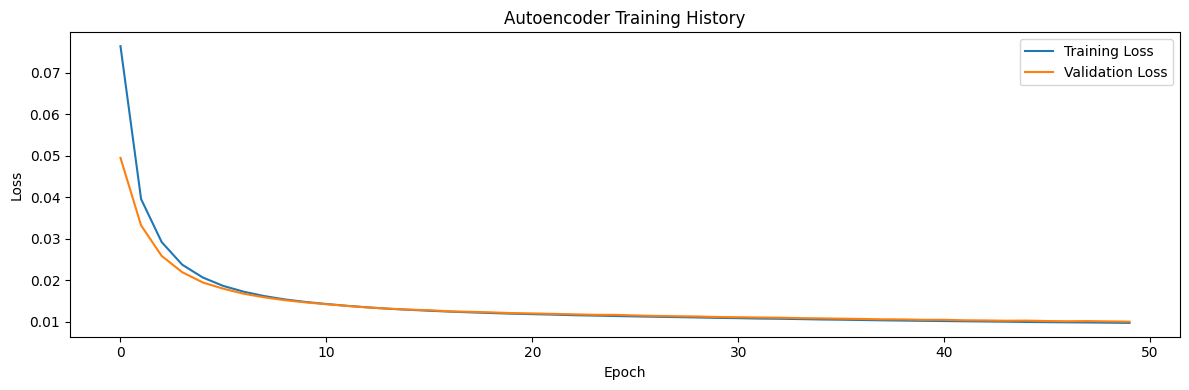


Mean Squared Error on test data: 0.009984


KeyError: 0

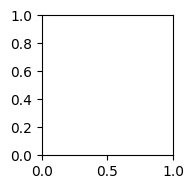

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST dataset using sklearn
def load_mnist_data():
    print("Loading MNIST dataset...")
    # Load MNIST dataset
    mnist = fetch_openml('mnist_784', version=1, parser='auto')
    X = mnist.data.astype('float32') / 255.0
    y = mnist.target.astype('int')
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test

# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Output values between 0 and 1
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, _ = data
                inputs = inputs.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                model.load_state_dict(best_model)
                break
    
    if epochs_no_improve < patience:
        print(f'Training completed for all {num_epochs} epochs')
        model.load_state_dict(best_model)
    
    return train_losses, val_losses

# Visualize original and reconstructed images
def visualize_reconstruction(X_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.tight_layout()
    plt.show()

# Visualize the data in latent space (2D) using t-SNE
def visualize_latent_space(encoded_data, labels):
    # If the encoding dimension is greater than 2, use t-SNE to reduce to 2D for visualization
    if encoded_data.shape[1] > 2:
        print("Applying t-SNE for visualization of the latent space...")
        tsne = TSNE(n_components=2, random_state=42)
        encoded_data_2d = tsne.fit_transform(encoded_data)
    else:
        encoded_data_2d = encoded_data
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Digit Class')
    plt.title('2D Visualization of Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Main function
def main():
    # Load data
    X_train, y_train, X_test, y_test = load_mnist_data()
    
    # Set the dimensions
    input_dim = X_train.shape[1]  # 784 for MNIST
    encoding_dim = 32  # Dimension of the latent space
    
    # Convert to PyTorch tensors - handle both DataFrame and numpy array inputs
    if hasattr(X_train, 'values'):
        X_train_tensor = torch.FloatTensor(X_train.values)
    else:
        X_train_tensor = torch.FloatTensor(X_train)
        
    if hasattr(y_train, 'values'):
        y_train_tensor = torch.LongTensor(y_train.values)
    else:
        y_train_tensor = torch.LongTensor(y_train)
        
    if hasattr(X_test, 'values'):
        X_test_tensor = torch.FloatTensor(X_test.values)
    else:
        X_test_tensor = torch.FloatTensor(X_test)
        
    if hasattr(y_test, 'values'):
        y_test_tensor = torch.LongTensor(y_test.values)
    else:
        y_test_tensor = torch.LongTensor(y_test)
    
    # Create train/validation split
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
    )
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_final, y_train_final)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    batch_size = 256
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model
    model = Autoencoder(input_dim, encoding_dim).to(device)
    
    # Print model summary
    print("\nAutoencoder Model Architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Autoencoder Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Encode and decode test data
    model.eval()
    with torch.no_grad():
        # Encode all test data
        encoded_data = []
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            encoded = model.encode(inputs)
            encoded_data.append(encoded.cpu().numpy())
        
        # Decode all test data
        decoded_data = []
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            decoded_data.append(outputs.cpu().numpy())
    
    # Concatenate batches
    encoded_imgs = np.vstack(encoded_data)
    decoded_imgs = np.vstack(decoded_data)
    
    # Calculate reconstruction error
    mse = np.mean(np.square(X_test - decoded_imgs))
    print(f"\nMean Squared Error on test data: {mse:.6f}")
    
    # Visualize original vs reconstructed images
    visualize_reconstruction(X_test, decoded_imgs)
    
    # Visualize the latent space
    y_test_values = y_test.values if hasattr(y_test, 'values') else y_test
    visualize_latent_space(encoded_imgs, y_test_values)
    
    # Example of using the encoder for dimensionality reduction
    print(f"\nOriginal dimension: {X_test.shape[1]}")
    print(f"Reduced dimension: {encoded_imgs.shape[1]}")
    print(f"Compression ratio: {X_test.shape[1] / encoded_imgs.shape[1]:.2f}x")

if __name__ == "__main__":
    main()